In [1]:
import pandas as pd
import numpy as np
import collections
from item.item_list import (
    ItemList,
    Item
)
from item.clustering.utils import (
    load_clustering_results_pickle,
    load_clustering_results
)
from collections import defaultdict, Counter
import time
from nlp.utils import (
    plot_histogram,
    get_completetext,
    plot_wordcloud,
    print_statistics,
    groups_frequency_sort)
import matplotlib.pyplot as plt
import pickle
import json
from statsmodels.distributions.empirical_distribution import ECDF

In [2]:
def save_pickle_file(file, data):

    with open(file, "wb") as PFile:
        pickle.dump(data, PFile)
    PFile.close()

In [3]:
def save_json_file(file, data):

    with open(file, "w") as JFile:
        json.dump(data, JFile)
    JFile.close()

# Load items and clustering results

In [4]:
results, outliers = load_clustering_results_pickle('../data/output/druid_fasttext/')

In [5]:
itemlist = ItemList()
itemlist.load_items_from_file('../data/output/druid_fasttext/f03_items.csv.zip')

In [6]:
items_df = itemlist.items_df

In [7]:
items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11482941 entries, 0 to 11482940
Data columns (total 19 columns):
 #   Column              Dtype  
---  ------              -----  
 0   palavras            object 
 1   unidades_medida     object 
 2   numeros             object 
 3   cores               object 
 4   materiais           object 
 5   tamanho             object 
 6   quantidade          object 
 7   preco               float64
 8   dsc_unidade_medida  object 
 9   original            object 
 10  licitacao           int64  
 11  original_prep       object 
 12  funcao              float64
 13  ano                 int64  
 14  mes                 int64  
 15  data                object 
 16  municipio           object 
 17  orgao               object 
 18  item_id             int64  
dtypes: float64(2), int64(4), object(13)
memory usage: 1.6+ GB


In [8]:
groups_df = pd.read_csv('../data/output/druid_fasttext/clusters.csv.zip', sep=';')

In [9]:
groups_df.head()

,item_id,grupo,grupo_ruido,item_ruido
0,307139,dorflex,1,1
1,596029,dorflex,1,1
2,699357,dorflex,1,1
3,1132522,dorflex,1,1
4,1399464,dorflex,1,1


In [10]:
len(items_df)

11482941

In [11]:
count = 0

for group, items_list in results.items():
    if '_' in group and "-1" not in group and len(items_list) >= 30:
#     if '_' in group and "-1" not in group:
        count += 1
    
count

39613

In [12]:
# Adiciona a informação de grupo e ruído no dataframe de itens
items_df = items_df.merge(groups_df, left_on='item_id', right_on='item_id')

In [13]:
# Exclui grupos de ruídos e grupos não particionados
items_df = items_df[items_df.item_ruido == 0]
items_df['original_desc'] = items_df['original_prep'].apply(lambda x: ' '.join(eval(x)))

In [14]:
items_df.set_index('grupo', inplace=True)

In [15]:
# Quantidade de descrições por grupo
groups_count_df = items_df.groupby('grupo', as_index=True).count().sort_values('item_id', ascending=False)['original_desc']
print(f'Quantidade de grupos considerados: {len(groups_count_df)}')

Quantidade de grupos considerados: 39613


In [16]:
groups_count_df

grupo
cartucho_3      42221
oleo_29         38754
pasta_11        32435
rolamento_15    25497
tinta_28        22970
                ...  
rolamento_29       30
orto_0             30
lamina_22          30
adulto_0           30
ceramico_25        30
Name: original_desc, Length: 39613, dtype: int64

In [17]:
len(results['cartucho_3'])

42221

In [18]:
items_df.set_index('item_id', inplace=True)

In [19]:
items_df.head()

,palavras,unidades_medida,numeros,cores,materiais,tamanho,quantidade,preco,dsc_unidade_medida,original,...,original_prep,funcao,ano,mes,data,municipio,orgao,grupo_ruido,item_ruido,original_desc
item_id,,,,,,,,,,,,,,,,,,,,,
0,"['torval', 'cr', 'com']",['mg'],"['500', '30']",[],[],[],['comprimido'],58.6500,caixa,TORVAL CR 500MG COM 30 COMPRIMIDOS,...,"['torval', 'cr', '500', 'mg', 'com', '30', 'co...",NaN,2014,11,2014-09-19,VARZELANDIA,PREFEITURA MUNICIPAL DE VARZELANDIA,0,0,torval cr 500 mg com 30 comprimido
1,['complexo'],['ml'],['30'],[],[],[],[],3.4150,frasco,COMPLEXO B 30 ML,...,"['complexo', 'b', '30', 'ml']",NaN,2014,11,2014-09-19,VARZELANDIA,PREFEITURA MUNICIPAL DE VARZELANDIA,0,0,complexo b 30 ml
2,"['estante', 'chapa', 'com', 'altura', 'mts']",[],"['22', '1', '98']",[],['aco'],[],[],196.0000,unidade,"ESTANTE DE ACO CHAPA 22 COM ALTURA DE 1,98 MTS",...,"['estante', 'aco', 'chapa', '22', 'com', 'altu...",NaN,2014,11,2014-10-23,VARZELANDIA,PREFEITURA MUNICIPAL DE VARZELANDIA,0,0,estante aco chapa 22 com altura 1 98 mts
3,"['broca', 'diamantado', 'cilindrico', 'plano',...",[],['3'],[],[],[],[],3.3333,unidade,3 BROCA DIAMANTADA CILINDRICA PLANA - ALTA,...,"['broca', 'diamantado', 'cilindrico', 'plano',...",NaN,2014,11,2014-09-02,VARZELANDIA,PREFEITURA MUNICIPAL DE VARZELANDIA,0,0,broca diamantado cilindrico plano alto 3
4,"['lustrar', 'mov', 'bas', 'silic', 'perf', 'sa...",[],[],[],[],[],[],4.0133,unidade,"LUSTRA, MOV, BAS SILIC, PERF SUAV, AC SEC RAPIDA",...,"['lustrar', 'mov', 'bas', 'silic', 'perf', 'sa...",NaN,2014,12,2014-12-02,VARZELANDIA,PREFEITURA MUNICIPAL DE VARZELANDIA,0,0,lustrar mov bas silic perf sav ac sec rapido


# Most frequent descriptions

In [20]:
def group_descriptions(items, results, cluster_name):
    
    descriptions_ids = results[cluster_name]
    cluster_items = list(items.loc[descriptions_ids]['original_desc'])
    
    return cluster_items

In [21]:
def descriptions_frequency(items, results, cluster_name, total_items=5, verbose=False):

    cluster_items = group_descriptions(items, results, cluster_name)

    num_items = len(cluster_items)
    descriptions = dict(Counter(cluster_items))
    top_descriptions = list(descriptions.items())
    top_descriptions.sort(key=lambda x: x[1], reverse=True)

    if verbose:
        for desc, freq in top_descriptions[:total_items]:
            print("{} ({:.2f}%)".format(desc, (freq/num_items)*100))
    
    most_freq_description = top_descriptions[0][0]
    tokens = most_freq_description.split()
    tokens.sort()
    tokens = ' '.join(tokens)
    frequency_perc = (top_descriptions[0][1]/num_items)*100
    
    return tokens, frequency_perc

In [22]:
desc, frequency = descriptions_frequency(items_df, results, 'gasolina_5', verbose=True, total_items=5)

gasolina (61.83%)
gasolina aditivado (19.49%)
gasolina comun (6.12%)
gasolina automotivo (5.71%)
gasolina tipo c (2.04%)


In [23]:
len(group_descriptions(items_df, results, 'cartucho_3'))

42221

In [24]:
len(set(group_descriptions(items_df, results, 'cartucho_3')))

21023

In [25]:
groups_count = groups_count_df.reset_index()

In [26]:
groups = groups_count.values.tolist()

In [27]:
groups

[['cartucho_3', 42221],
 ['oleo_29', 38754],
 ['pasta_11', 32435],
 ['rolamento_15', 25497],
 ['tinta_28', 22970],
 ['prestacao_2', 22586],
 ['livro_20', 21712],
 ['livro_18', 18706],
 ['bomba_20', 18449],
 ['caneta_21', 16184],
 ['mesa_10', 14571],
 ['filtro_1', 14192],
 ['papel_67', 13339],
 ['item_2', 11918],
 ['lampada_21', 11426],
 ['luva_7', 11079],
 ['cabo_50', 10619],
 ['amortecedor_12', 10457],
 ['tubo_21', 10194],
 ['atadura_16', 10131],
 ['correia_13', 10057],
 ['filtro_69', 10032],
 ['veiculo_5', 9947],
 ['seguro_1', 9941],
 ['parafuso_17', 9653],
 ['fita_15', 9412],
 ['jogo_13', 9355],
 ['cabo_55', 9205],
 ['luva_102', 8805],
 ['luva_46', 8697],
 ['confeccao_4', 8559],
 ['armario_11', 8454],
 ['pasta_28', 8246],
 ['tubo_36', 8219],
 ['fralda_16', 7902],
 ['cadeira_13', 7440],
 ['cartao_10', 7321],
 ['etiqueta_6', 7134],
 ['coxim_18', 7082],
 ['broca_1', 7032],
 ['pano_17', 6992],
 ['broca_19', 6930],
 ['com_13', 6720],
 ['aparelho_8', 6667],
 ['tinta_7', 6642],
 ['fralda_1

### Count frequecies for each group

In [28]:
start = time.time()
desc_most_freq = []
frequencies = []
min_size = 0

for group_items in groups:
    group = group_items[0]
    num_items = group_items[1]
    if "_" not in group or "-1" in group:
        continue
    if num_items >= min_size:
        desc, frequency = descriptions_frequency(items_df, results, group)
        desc_most_freq.append((group, desc, frequency, num_items))
        frequencies.append(frequency)
        
print((time.time() - start)/60, 'minutes')

1.1390801906585692 minutes


In [29]:
len(desc_most_freq)

39613

In [30]:
for group in desc_most_freq:
    if group[2] > 50 and group[2] < 60:
        print(group)

('brita_7', '1 brita', 54.52147701582517, 2654)
('carbamazepina_22', '200 carbamazepina mg', 52.43856332703214, 2645)
('pimentao_8', 'pimentao', 52.117512399847385, 2621)
('furosemida_8', '40 furosemida mg', 53.735632183908045, 2436)
('paracetamol_24', '500 mg paracetamol', 53.766556291390735, 2416)
('haloperidol_17', '5 haloperidol mg', 51.3604018417748, 2389)
('clonazepam_22', '2 clonazepam mg', 59.07136715391229, 2326)
('captopril_2', '25 captopril mg', 55.70004334633724, 2307)
('espironolactona_3', '25 espironolactona mg', 59.173913043478265, 2300)
('atenolol_6', '50 atenolol mg', 57.52289576973397, 2293)
('prednisona_7', '20 mg prednisona', 54.75982532751091, 2290)
('acido_30', '5 acido folico mg', 53.26566637246248, 2266)
('hidroclorotiazida_2', '25 hidroclorotiazida mg', 57.06570657065707, 2222)
('ibuprofeno_25', '600 ibuprofeno mg', 53.71789094186571, 2219)
('azitromicina_20', '500 azitromicina mg', 56.04746691008672, 2191)
('cefalexina_22', '500 cefalexina mg', 57.870370370370

### Frequencies distribution

In [31]:
def plot_ecdf(values, x_label, y_label, xline=None):

    # fit a cdf
    ecdf = ECDF(values)

    fig, (axis1) = plt.subplots(figsize=(10,8))

    plt.plot(ecdf.x, ecdf.y)

    if xline != None:
        plt.axvline(x=xline, linestyle='--', color='r')

    axis1.set_xlabel(x_label, fontsize=20, weight='bold')
    axis1.set_ylabel(y_label, fontsize=20, weight='bold')

    plt.grid(axis='both', linestyle=':', linewidth=1.0)

    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)

    plt.show()
    plt.clf()

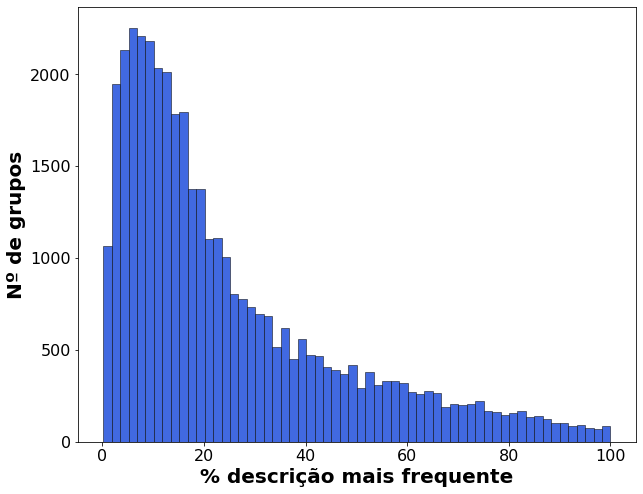

<Figure size 432x288 with 0 Axes>

In [32]:
plot_histogram(frequencies, 60, '% descrição mais frequente', 'Nº de grupos', log=False)

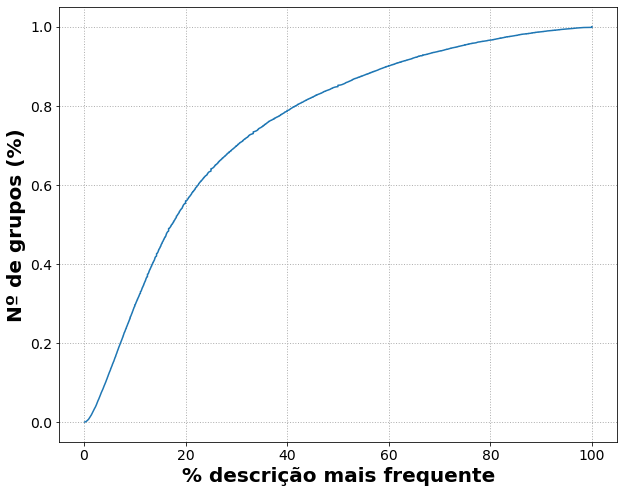

<Figure size 432x288 with 0 Axes>

In [33]:
plot_ecdf(frequencies, '% descrição mais frequente', 'Nº de grupos (%)')

In [34]:
# frequencies distribution
print_statistics(frequencies)

Mean: 25.123302876217977
First quartile: 8.695652173913043
Median: 17.307692307692307
Third quartile: 35.38461538461539
Std: 22.144324380853593
Var: 490.3711022844669
Max: 100.0
Min: 0.15034767900770532


In [35]:
descriptions = [group[1] for group in desc_most_freq]

In [36]:
description_count = defaultdict(list)

for desc in desc_most_freq:
    description_count[desc[1]].append(desc[0])

In [37]:
count = 0

for desc, subgroups in description_count.items():
    if len(subgroups) > 1:
        count += 1

count

268

In [38]:
len(descriptions)

39613

In [39]:
# number of unique descriptions
len(descriptions) - len(description_count)

275

## Save new groups

In [40]:
def get_group_name(subgroups):
    first_token = str(subgroups[0].split('_')[0])
    ids = ""
    for group in subgroups:
        id_ = str(group.split('_')[1])
        ids += "_" + id_
    
    return first_token + ids

In [41]:
desc_canon_groups = collections.defaultdict(list)

for desc, subgroups in description_count.items():
    subgroups.sort()
    group_name = get_group_name(subgroups)
    group_info = {'description': desc,
             'groups': subgroups
            }
    desc_canon_groups[group_name] = group_info

In [48]:
len(desc_canon_groups)

39341

In [49]:
desc_canon_groups['alcool_20']

{'description': '0 1 1000 alcool iodado ml', 'groups': ['alcool_20']}

In [152]:
save_json_file('../data/output/druid_fasttext/desc+freq_groups.json', desc_canon_groups)

# Most frequent tokens in the descriptions

In [31]:
def tokens_desc_frequency(items, results, cluster_name, num_tokens=10, min_freq=50):

    cluster_items = group_descriptions(items, results, cluster_name)
    num_items = len(cluster_items)

    tokens_freq = defaultdict(int)
    for desc in cluster_items:
        tokens = set(desc.split())
        for token in tokens:
            tokens_freq[token] += 1

    top_tokens = list(tokens_freq.items())
    top_tokens.sort(key=lambda x:x[1], reverse=True)
    top_tokens = [(token, 100*(freq/num_items)) for token, freq in top_tokens if 100*(freq/num_items) >= min_freq]

    tokens_description = [token for token, freq in top_tokens[:num_tokens]]
    tokens_description.sort()
    description = ' '.join(tokens_description)
    
    return top_tokens[:num_tokens], description

In [32]:
len(groups)

39613

In [155]:
start = time.time()
most_freq_tokens = []
tokens_frequencies = []
descriptions_tok = []
min_freq = 30
num_tokens = 5
min_size = 0

for group_items in groups:
    group = group_items[0]
    num_items = group_items[1]
    if num_items >= min_size:
        top_tokens, description = tokens_desc_frequency(items_df, results,
                                                        group, num_tokens=num_tokens,
                                                        min_freq=min_freq)
        descriptions_tok.append((group, description, num_items))
        for token, freq in top_tokens:
            most_freq_tokens.append(token)
            tokens_frequencies.append(freq)

print((time.time() - start)/60, 'minutes')

1.1739919980367024 minutes


In [156]:
len(most_freq_tokens)

157108

### Frequencies distribution

In [ ]:
plot_histogram(tokens_frequencies, 60, '% tokens mais frequentes', 'Nº de tokens', log=False)

In [ ]:
# without first token
plot_histogram([v for v in tokens_frequencies if v != 100.0], 60, '% tokens mais frequentes', 'Nº de tokens', log=False)

In [ ]:
plot_ecdf(tokens_frequencies, '% tokens mais frequentes', 'Nº de tokens (%)')

In [ ]:
plot_ecdf([v for v in tokens_frequencies if v != 100.0], '% tokens mais frequentes', 'Nº de tokens (%)')

In [ ]:
# tokens frequencies distribution
print_statistics(tokens_frequencies)

In [ ]:
len(most_freq_tokens)

In [ ]:
# unique tokens
len(set(most_freq_tokens))

In [ ]:
descriptions_tok[:5]

In [ ]:
desc, frequency = descriptions_frequency(items_df, results, 'pasta_5', verbose=True, total_items=100)

### Count descriptions

In [ ]:
descriptions_tok[:5]

In [ ]:
description_tok_count = defaultdict(list)

for desc in descriptions_tok:
    description_tok_count[desc[1]].append(desc[0])

In [ ]:
len(descriptions_tok)

In [ ]:
len(descriptions_tok) - len(description_tok_count)

In [ ]:
count = 0

for desc, subgroups in description_tok_count.items():
    if len(subgroups) > 1:
        count += 1

count

In [ ]:
# final number of groups
len(description_tok_count)

## Save new groups

In [ ]:
desctok_canon_groups = collections.defaultdict(list)

for desc, subgroups in description_tok_count.items():
    subgroups.sort()
    group_name = get_group_name(subgroups)
    group_info = {'description': desc,
             'groups': subgroups
            }
    desctok_canon_groups[group_name] = group_info

In [ ]:
len(desctok_canon_groups)

In [ ]:
save_json_file('../data/output/druid_fasttext/tok+freq_groups_top5_30.json', desctok_canon_groups)